# Описание задачи
**Промышленность**

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Нужно построить модель, которая предскажет температуру стали.

# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

# План работы:
1. Подготовка и анализ данных (проверить каждый датасет на дубликаты, пропуски, типы данных)
2. Предобработка данных (работа с проспусками и выбросами)
3. Подготовка данных (проверка на мультиколлинеарность, формирование итоговых датафреймовб формирование целевого и остальных признаков, составление таблицы со всеми данными для модели, разделение на выборки)
4. Обучение моделей (LGBMRegressor, Random Forest, Linear Regression, CatBoostRegressor)
5. Тестирование (анализ важности факторов у модели-победителя)
6. Выводы

## Подготовка данных

In [1]:
#from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore') 

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [4]:
df_names = 'data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time'
try:
    arc, bulk, bulk_time, gas, temp, wire, wire_time =\
    (pd.read_csv(f'/datasets/final_steel/{name}.csv') for name in df_names)
except:
    arc, bulk, bulk_time, gas, temp, wire, wire_time = \
        (pd.read_csv(f'{name}.csv') for name in df_names)

**Данные об электродах**

In [5]:
#arc = pd.read_csv('/content/drive/My Drive/final_steel/data_arc.csv')
arc.info()
arc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [6]:
arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [7]:
len(arc['key'].unique())

3214

In [8]:
arc.duplicated().sum()

0

In [9]:
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'])
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'])

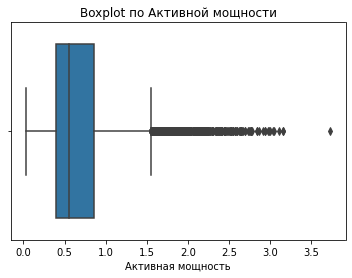

In [10]:
sns.boxplot(data=arc, x=arc['Активная мощность'])
plt.title('Boxplot по Активной мощности')
plt.show()

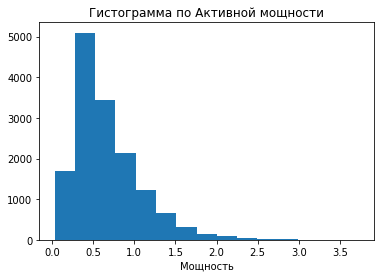

In [11]:
plt.hist(arc['Активная мощность'], bins=15)
plt.title('Гистограмма по Активной мощности')
plt.xlabel("Мощность")
plt.show()

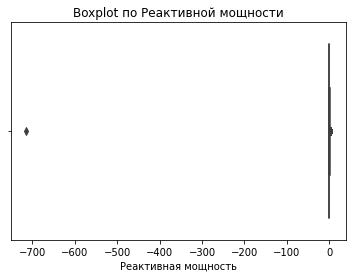

In [12]:
sns.boxplot(data=arc, x=arc['Реактивная мощность'])
plt.title('Boxplot по Реактивной мощности')
plt.show()

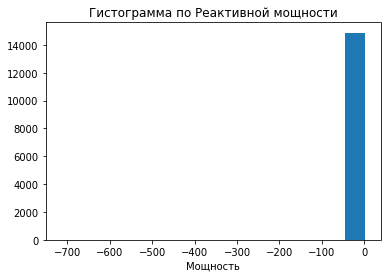

In [13]:
plt.hist(arc['Реактивная мощность'], bins=15)
plt.title('Гистограмма по Реактивной мощности')
plt.xlabel("Мощность")
plt.show()

**По датасету arc**

- Пропусков нет
- Дубликатов нет
- Отрицательные значения в столбцу Реактивная мощность
- Видны выбросы по столбцу Активная мощность
- Привели столбцы Начало и Конец нагрева дугой к типу datetime



**Данные о подаче сыпучих материалов (объём)**

In [14]:
#bulk = pd.read_csv('/content/drive/My Drive/final_steel/data_bulk.csv')
bulk.info()
bulk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [15]:
bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [16]:
len(bulk['key'].unique())

3129

In [17]:
bulk.duplicated().sum()

0

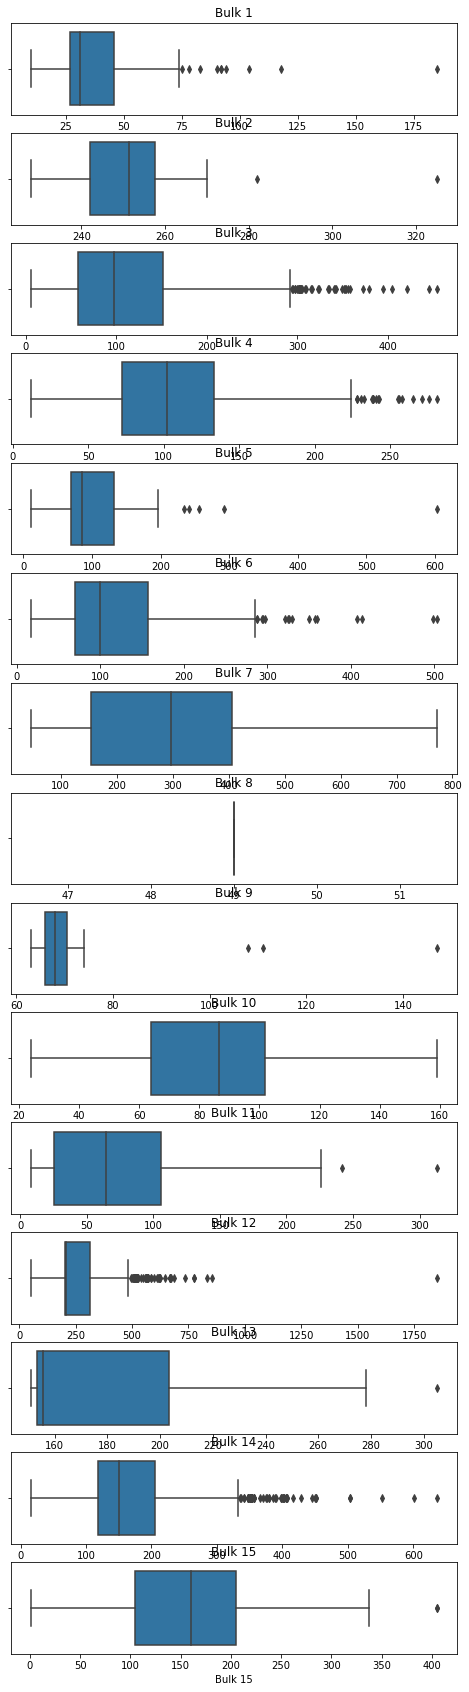

In [18]:
#Посмотрим на выбросы
fig, axes = plt.subplots(15,1, figsize=(8,30))
for i, j in zip(bulk.columns[1:], range(bulk.shape[1]+1)):
                    sns.boxplot(bulk[i], ax=axes[j])
                    axes[j].set_title(i)

**По датасету bulk**

- Много пропусков
- Дубликатов нет

**Данные о подаче сыпучих материалов (время)**

In [19]:
#bulk_time = pd.read_csv('/content/drive/My Drive/final_steel/data_bulk_time.csv')
bulk_time.info()
bulk_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


 **Данные о продувке сплава газом**

In [20]:
#gas = pd.read_csv('/content/drive/My Drive/final_steel/data_gas.csv')
gas.info()
gas.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [21]:
gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [22]:
len(gas['key'].unique())

3239

In [23]:
gas.duplicated().sum()

0

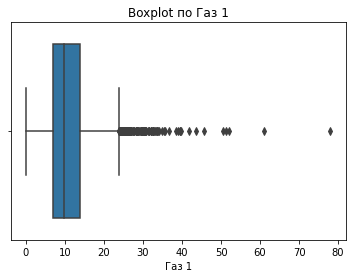

In [24]:
sns.boxplot(data=gas, x=gas['Газ 1'])
plt.title('Boxplot по Газ 1')
plt.show()

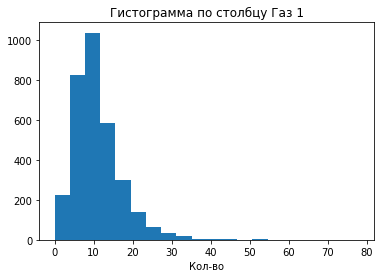

In [25]:
plt.hist(gas['Газ 1'], bins=20)
plt.title('Гистограмма по столбцу Газ 1')
plt.xlabel("Кол-во")
plt.show()

**По датасету gas**

- Пропусков нет
- Дубликатов нет
- Выбросы в столбце Газ 1

**Результаты измерения температуры**

In [26]:
#temp = pd.read_csv('/content/drive/My Drive/final_steel/data_temp.csv')
temp.info()
temp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [27]:
temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [28]:
temp.duplicated().sum()

0

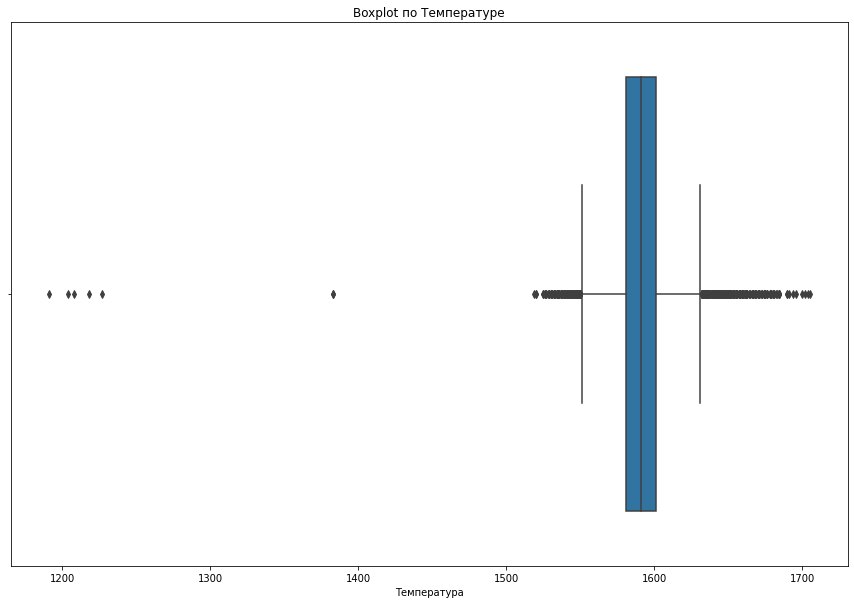

In [29]:
plt.figure(figsize=(15,10))
sns.boxplot(data = temp, x = temp['Температура'])
plt.title('Boxplot по Температуре')
plt.show()

In [30]:
temp.loc[temp['Температура'] <= 1500].shape

(7, 3)

In [31]:
temp.tail(5)

,key,Время замера,Температура
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


**По датасету temp**
- Пропуски в столбце Температура 
- Дубликтов нет
- Выбросы в столбце Температура 
- На последних этапах отсутсвуют измерения финальной температуры

**Данные о проволочных материалах (объём)**

In [32]:
#wire = pd.read_csv('/content/drive/My Drive/final_steel/data_wire.csv')
wire.info()
wire.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [34]:
wire.duplicated().sum()

0

**По датасету wire**

- Много пропусков 
- Дубликатов нет

 **Данные о проволочных материалах (время)**

In [35]:
#wire_time = pd.read_csv('/content/drive/My Drive/final_steel/data_wire_time.csv')
wire_time.info()
wire_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
wire_time.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


### Выводы: 

Что нужно сделать в дальнейшем: 

- Убрать пропуски, где это возможно
- В датасетах, связанных с временим изменить типы данных на datetime
- Избавиться от выбросов

## Предобработка данных

In [37]:
arc = arc[arc['Реактивная мощность'] > 0]
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'])
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'])
arc['Время нагрева дугой'] = (arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']) // pd.Timedelta('1s')
arc['Полная мощность'] = np.sqrt(arc['Активная мощность']**2 + arc['Реактивная мощность']**2)

In [38]:
arc_count = arc['key'].value_counts().sort_index().sort_index().reset_index()
arc_count = arc_count.rename(columns={'index': 'key',
                          'key': 'Кол-во запусков нагрева'})
arc = arc.groupby(by = 'key', as_index=False).sum()
arc = arc.merge(arc_count, how='left', on='key')

In [39]:
# Удалим выбросы в Температуре 
Q1 = np.percentile(temp['Температура'].dropna(), 25, interpolation = 'midpoint')
Q3 = np.percentile(temp['Температура'].dropna(), 75, interpolation = 'midpoint')  
median =  temp['Температура'].median()
IQR = Q3 - Q1

In [40]:
_temp = temp[(temp['Температура']<(Q1 - 3*IQR)) |(temp['Температура']>(Q3 + 3*IQR))]['key'].unique()
_drop_temp = temp.query('key in @_temp').index

print('Количество удаленных строк',len(_drop_temp))
print('Количество удаленных партий',len(_temp))
temp =  temp.drop(index=_drop_temp)

Количество удаленных строк 241
Количество удаленных партий 42


In [41]:
temp['Время замера'] =temp['Время замера'].astype('datetime64[ns]')

In [42]:
#Посчитаем количество замеров температуры для каждой партии
_temp_quant = temp.groupby(by='key').count().reset_index()\
.rename(columns={"Время замера":"Кол-во замеров температуры"})\
.drop('Температура',axis=1)

In [43]:
_tmp_tem = temp.groupby(by='key').count().reset_index()['Время замера'].value_counts()

In [44]:
_tmp_temp_na = temp[temp.isna().any(axis=1)].groupby(by='key').count().reset_index()['Время замера'].value_counts()

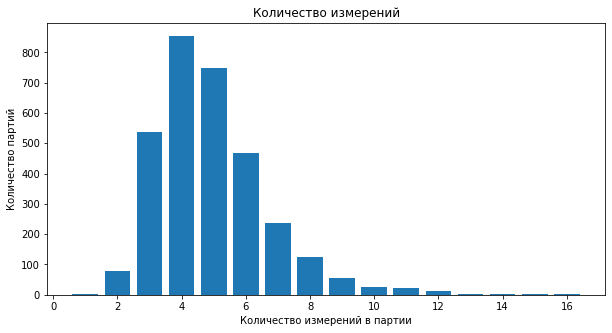

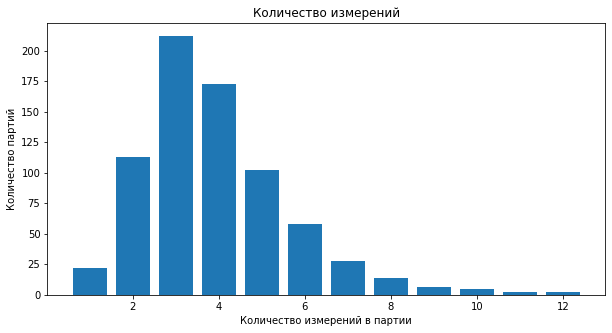

In [45]:
for df in [_tmp_tem,_tmp_temp_na]:
    df = df.reset_index().rename(columns={"index":"Temperature_in_key","Время замера":"Quantity_key"})
    plt.figure(figsize=(10,5))
    ax = plt.bar(df['Temperature_in_key'].to_list(),df['Quantity_key'].to_list());
    plt.xlabel('Количество измерений в партии')
    plt.ylabel('Количество партий')
    plt.title(f'Количество измерений')

In [46]:
temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [47]:
# Длительность времени между первым и последним замером температуры
key_unique = temp['key'].unique()
time_measure_temp = []
for key in key_unique:
    _df =temp[temp['key']==key]
    dfiff_time =_df['Время замера'].max()-_df['Время замера'].min()
    time_measure_temp.append([key,dfiff_time.seconds])
temp_gap = pd.DataFrame(time_measure_temp,columns = ['key','time_gap'])

In [48]:
for key in key_unique:
    temp[temp['key']==key]   

In [49]:
#Найдем все значения выплавок, где последнее значение температуры было пропущено

key_unique = temp['key'].unique()
last_nan_key = []
for key in key_unique:
    len_key_df = temp[temp['key']==key]['key'].count()
    if pd.isna(temp[temp['key']==key].iloc[len_key_df-1]['Температура']):  
        last_nan_key.append(key)
temp.query('key in @last_nan_key ')

,key,Время замера,Температура
12267,2500,2019-08-06 03:11:31,1539.0
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12271,2501,2019-08-06 03:44:42,1587.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [50]:
temp = temp.drop(index=temp.query('key in @last_nan_key ').index)
temp.info()
print ('Количество удаленных партий',len(last_nan_key))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12037 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           12037 non-null  int64         
 1   Время замера  12037 non-null  datetime64[ns]
 2   Температура   12037 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 376.2 KB
Количество удаленных партий 737


In [51]:
# СКО у всех температур кроме последней
key_unique = temp['key'].unique()
std_key = []
for key in key_unique:
    len_key_df = temp[temp['key']==key]['key'].count()
    std = temp[temp['key']==key]['Температура'][:len_key_df-1].values.std()
    first_temp = temp[temp['key']==key]['Температура'].iloc[0]
    last_temp = temp[temp['key']==key]['Температура'].iloc[len_key_df-1]
    std_key.append([key,std,first_temp,last_temp])     

In [52]:
std_key = pd.DataFrame(std_key,columns=['key','std_temp','first_temp','last_temp'])
std_key.info()
std_key = std_key.dropna()
std_key.tail(7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2437 entries, 0 to 2436
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2437 non-null   int64  
 1   std_temp    2435 non-null   float64
 2   first_temp  2437 non-null   float64
 3   last_temp   2437 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 76.3 KB


,key,std_temp,first_temp,last_temp
2430,2493,6.500000,1599.0,1594.0
2431,2494,3.500000,1585.0,1591.0
2432,2495,10.000000,1570.0,1591.0
2433,2496,16.753109,1554.0,1591.0
2434,2497,0.000000,1571.0,1589.0
2435,2498,9.233093,1591.0,1594.0
2436,2499,17.500000,1569.0,1603.0


In [53]:
df_temp= temp_gap.merge(std_key,how='inner',on='key')
df_temp=_temp_quant.merge(df_temp,how='inner',on='key')
df_temp

,key,Кол-во замеров температуры,time_gap,std_temp,first_temp,last_temp
0,1,5,861,17.124544,1571.0,1613.0
1,2,6,1305,12.286578,1581.0,1602.0
2,3,5,1300,1.118034,1596.0,1599.0
3,4,3,388,11.000000,1601.0,1625.0
4,5,2,762,0.000000,1576.0,1602.0
...,...,...,...,...,...,...
2430,2495,3,1137,10.000000,1570.0,1591.0
2431,2496,4,1618,16.753109,1554.0,1591.0
2432,2497,2,717,0.000000,1571.0,1589.0
2433,2498,5,1302,9.233093,1591.0,1594.0


In [54]:
#Удалим явные выбросы по газу
gas = gas[gas['Газ 1']<40]
gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [55]:
# Пропущенные значение в bulk
_bulk = bulk[['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15']].fillna(0)
_bulk

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


In [56]:
bulk = pd.merge(bulk['key'],_bulk, right_index = True,left_index = True)
bulk.tail()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0
3128,3241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.0,52.0


In [57]:
# Пропущенные значение в wire
_wire = wire[['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9']].fillna(0)
_wire

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3076,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
wire = pd.merge(wire['key'],_wire, right_index = True,left_index = True)
wire.tail()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,38.088959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3080,3241,63.117595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
# объединяем данные
df = (wire.merge(bulk, how = 'inner', on = 'key')
                 .merge(arc, how = 'inner', on = 'key')
                 .merge(gas, how = 'inner', on = 'key')
                 .merge(df_temp, how = 'inner', on = 'key')
       )
df

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,...,Реактивная мощность,Время нагрева дугой,Полная мощность,Кол-во запусков нагрева,Газ 1,Кол-во замеров температуры,time_gap,std_temp,first_temp,last_temp
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.183241,1098,5.826395,5,29.749986,5,861,17.124544,1571.0,1613.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.998112,811,3.649216,4,12.555561,6,1305,12.286578,1581.0,1602.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.599076,655,2.989534,5,28.554793,5,1300,1.118034,1596.0,1599.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.060298,741,3.814962,4,18.841219,3,388,11.000000,1601.0,1625.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.252643,869,4.035758,4,5.413692,2,762,0.000000,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2308,2495,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.360777,723,3.986869,4,7.125735,3,1137,10.000000,1570.0,1591.0
2309,2496,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.810185,940,5.057033,6,9.412616,4,1618,16.753109,1554.0,1591.0
2310,2497,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.851269,569,2.885017,3,6.271699,2,717,0.000000,1571.0,1589.0
2311,2498,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.355428,750,4.143749,5,14.953657,5,1302,9.233093,1591.0,1594.0


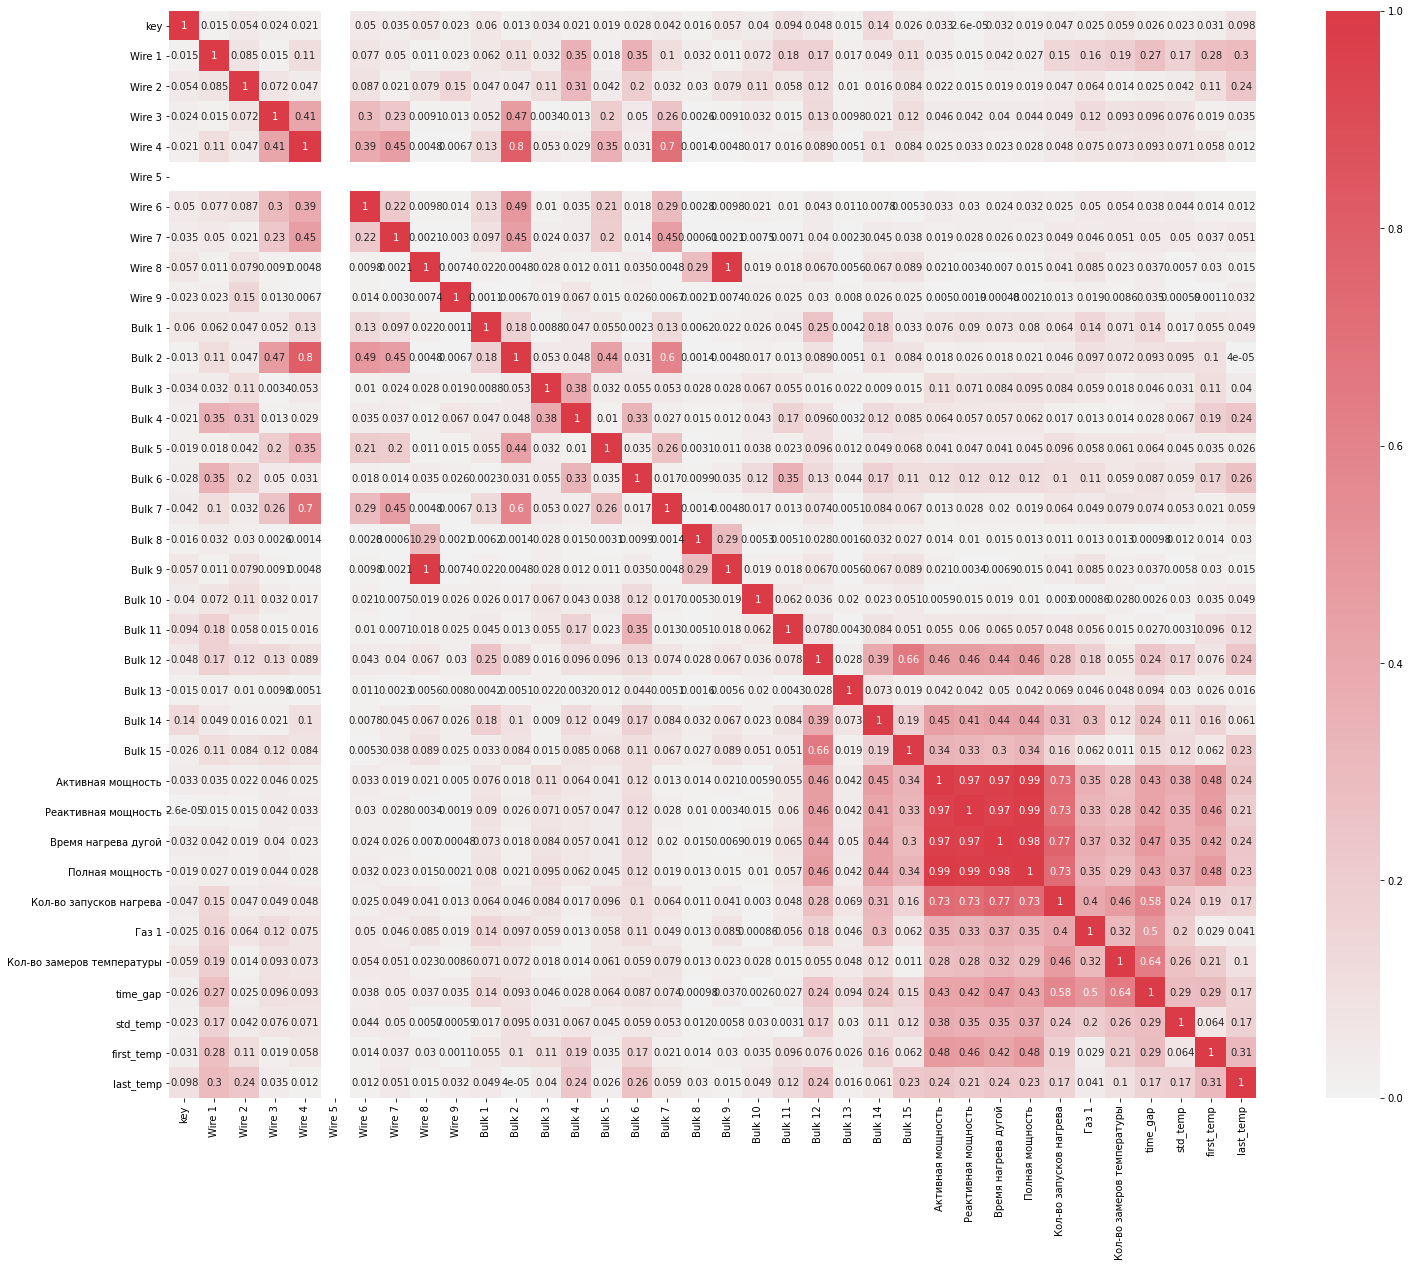

In [60]:
from scipy.stats import spearmanr
# Проверим получившийся датасет по матрице корреляций
corr = abs(df.corr(method="spearman"))
f, ax = plt.subplots(figsize=(25, 20))
font = {'size': 10}
plt.rc('font', **font)

cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(
    corr,          
    cmap=cmap,    
    annot=True,   
    vmax=1,      
    vmin=0,     
    center=0,     
    square=True,   
    linewidths=0, 
    xticklabels=True, yticklabels=True)

Удалим сильно коррелирующие столбцы, чтобы модели не переобучались

In [61]:
df = df.drop(['Wire 8'], axis = 1)

In [62]:
df = df.drop(['Активная мощность', 'Реактивная мощность', 'Время нагрева дугой'], axis = 1)

In [63]:
df = df.drop(['key'], axis = 1)

In [64]:
df = df.drop(['Wire 5'], axis = 1)

In [65]:
df = df.drop(['std_temp'], axis = 1)

In [66]:
df = df.drop(['Кол-во замеров температуры'], axis = 1)

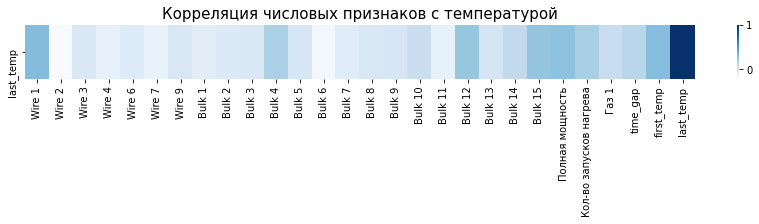

In [67]:
num=df.select_dtypes(exclude='object')
numcorr=num.corr()
f,ax=plt.subplots(figsize=(15,1))
sns.heatmap(numcorr.sort_values(by=['last_temp'], ascending=False).head(1), cmap='Blues')
plt.title("Корреляция числовых признаков с температурой", fontsize=15)
plt.show()

In [68]:
df = df.rename(columns={'Полная мощность': 'power',
                        'Кол-во запусков нагрева':'number_heating',
                        'Газ 1': 'gas 1'})

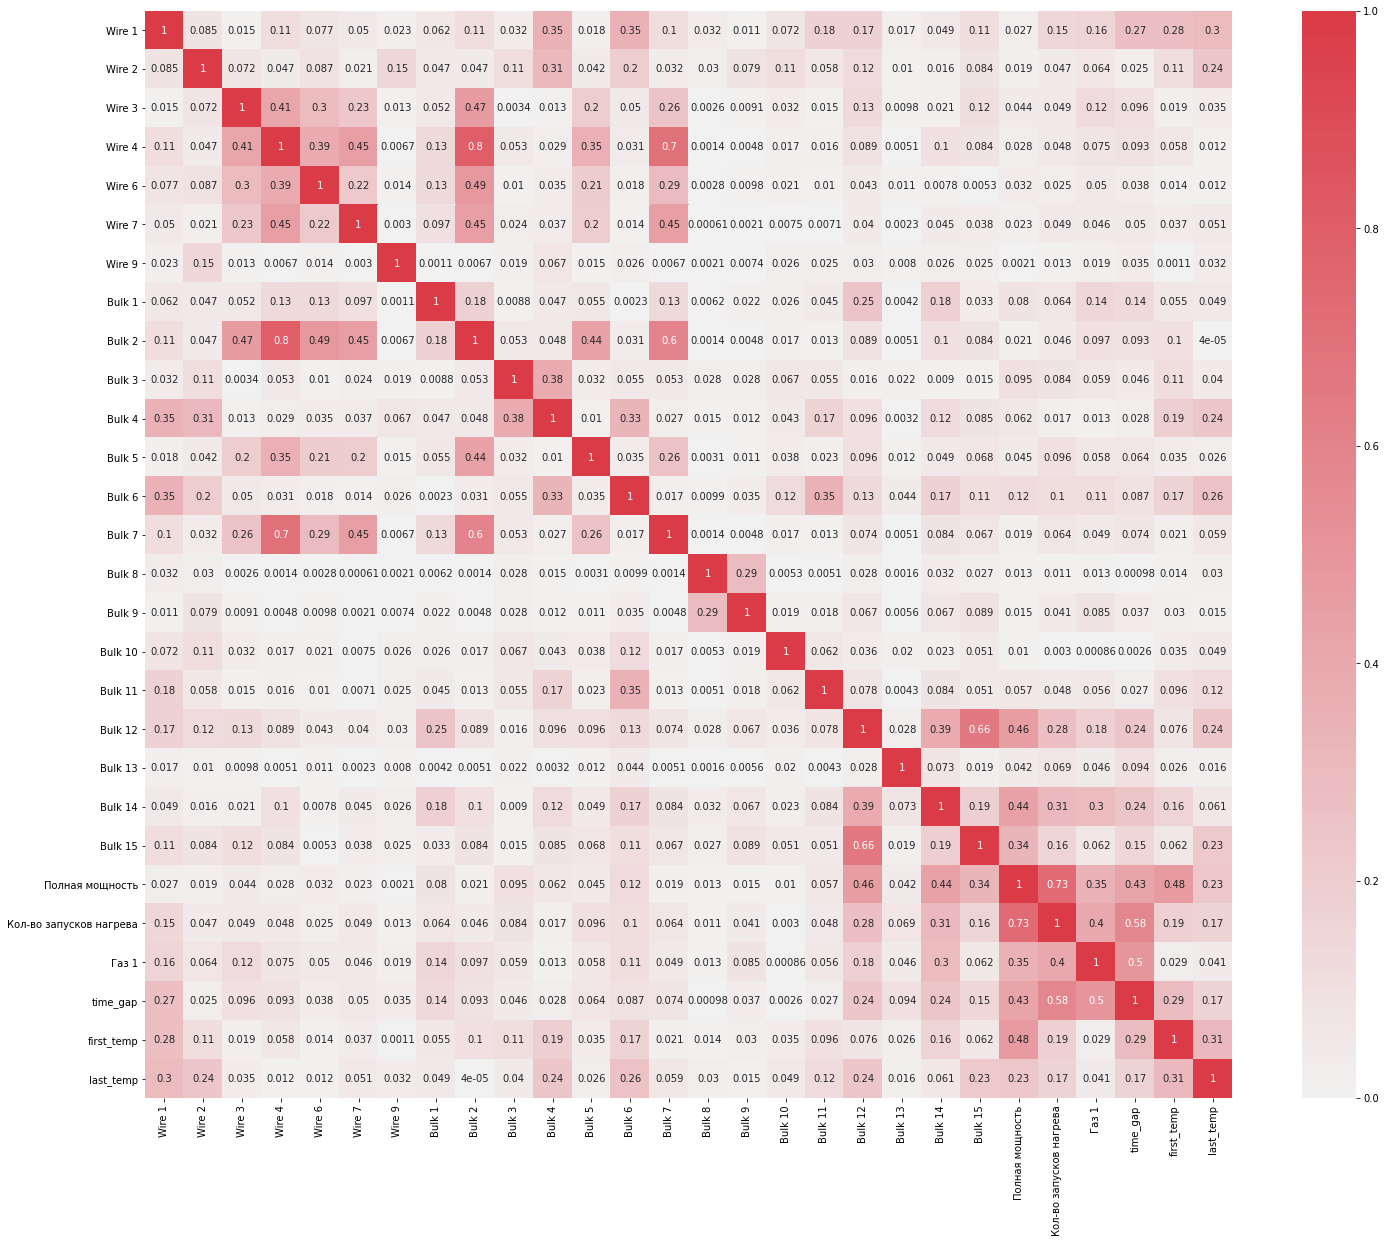

In [68]:
from scipy.stats import spearmanr
# Проверим получившийся датасет по матрице корреляций
corr = abs(df.corr(method="spearman"))
f, ax = plt.subplots(figsize=(25, 20))
font = {'size': 10}
plt.rc('font', **font)

cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(
    corr,          
    cmap=cmap,    
    annot=True,   
    vmax=1,      
    vmin=0,     
    center=0,     
    square=True,   
    linewidths=0, 
    xticklabels=True, yticklabels=True)

In [69]:
df

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 9,Bulk 1,Bulk 2,Bulk 3,...,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Полная мощность,Кол-во запусков нагрева,Газ 1,time_gap,first_temp,last_temp
0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,206.0,0.0,150.0,154.0,5.826395,5,29.749986,861,1571.0,1613.0
1,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,206.0,0.0,149.0,154.0,3.649216,4,12.555561,1305,1581.0,1602.0
2,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,205.0,0.0,152.0,153.0,2.989534,5,28.554793,1300,1596.0,1599.0
3,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,207.0,0.0,153.0,154.0,3.814962,4,18.841219,388,1601.0,1625.0
4,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,203.0,0.0,151.0,152.0,4.035758,4,5.413692,762,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2308,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,...,256.0,0.0,129.0,223.0,3.986869,4,7.125735,1137,1570.0,1591.0
2309,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,256.0,0.0,129.0,226.0,5.057033,6,9.412616,1618,1554.0,1591.0
2310,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,230.0,0.0,124.0,226.0,2.885017,3,6.271699,717,1571.0,1589.0
2311,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,...,206.0,0.0,129.0,207.0,4.143749,5,14.953657,1302,1591.0,1594.0


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2313 entries, 0 to 2312
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Wire 1          2313 non-null   float64
 1   Wire 2          2313 non-null   float64
 2   Wire 3          2313 non-null   float64
 3   Wire 4          2313 non-null   float64
 4   Wire 6          2313 non-null   float64
 5   Wire 7          2313 non-null   float64
 6   Wire 9          2313 non-null   float64
 7   Bulk 1          2313 non-null   float64
 8   Bulk 2          2313 non-null   float64
 9   Bulk 3          2313 non-null   float64
 10  Bulk 4          2313 non-null   float64
 11  Bulk 5          2313 non-null   float64
 12  Bulk 6          2313 non-null   float64
 13  Bulk 7          2313 non-null   float64
 14  Bulk 8          2313 non-null   float64
 15  Bulk 9          2313 non-null   float64
 16  Bulk 10         2313 non-null   float64
 17  Bulk 11         2313 non-null   f

Делим данные на выборки и масштабируем признаки

In [71]:
random_state = 3102022
train, test = train_test_split(df, test_size = 0.25, random_state = random_state)
cv_counts = 7

In [72]:
#масштабирование признаков

numeric = df.columns.tolist()
numeric = [i for i in numeric if i not in ('last_temp')]
scaler = MinMaxScaler()
scaler.fit(train[numeric])
train[numeric] = scaler.transform(train[numeric])
test[numeric] = scaler.transform(test[numeric])

In [73]:
x_train = train.drop(['last_temp'], axis = 1)
y_train = train['last_temp']
x_test = test.drop(['last_temp'], axis = 1)
y_test = test['last_temp']

## Обучение моделей

Linear Regression

In [74]:
from sklearn.model_selection import cross_val_score

In [75]:
%%time

regressor = LinearRegression()
cv_MAE_LR = (cross_val_score(regressor, 
                             x_train, 
                             y_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('MAE from CV of LinearRegression =', cv_MAE_LR)

MAE from CV of LinearRegression = 5.660862082112348
CPU times: user 140 ms, sys: 197 ms, total: 336 ms
Wall time: 287 ms


Random Forest

In [76]:
%%time

regressor = RandomForestRegressor(random_state=random_state) 
hyperparams = [{'criterion':['mse'],
                'n_estimators':[x for x in range(100, 700, 50)], 
                'max_depth': [2, 4, 6], 
                'min_samples_split': [2, 5, 8]}]

clf = GridSearchCV(regressor,
                   hyperparams, 
                   scoring='neg_mean_absolute_error', 
                   cv=cv_counts)
clf.fit(x_train, y_train)
best_params_RFR = clf.best_params_
print(clf.best_params_)
print()
means = clf.cv_results_['mean_test_score']
for mean, params in zip(means, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_RFR = (max(means)*-1)

{'criterion': 'mse', 'max_depth': 6, 'min_samples_split': 5, 'n_estimators': 200}

7.016192 for {'criterion': 'mse', 'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 100}
7.017870 for {'criterion': 'mse', 'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 150}
7.024361 for {'criterion': 'mse', 'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 200}
7.021214 for {'criterion': 'mse', 'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 250}
7.018885 for {'criterion': 'mse', 'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 300}
7.018823 for {'criterion': 'mse', 'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 350}
7.020071 for {'criterion': 'mse', 'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 400}
7.018180 for {'criterion': 'mse', 'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 450}
7.015141 for {'criterion': 'mse', 'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 500}
7.013022 for {'criterion': 'mse', 'max_depth': 2, 'min_samples

LGBMRegressor

In [77]:
%%time

regressor = LGBMRegressor(random_state=random_state) 
hyperparams = [{'boosting_type' : ['gbdt'],
                 'n_estimators': [500], 
                  'learning_rate': [0.01, 0.3],
                  'max_depth': range(3, 12)}]

clf = GridSearchCV(regressor, 
                   hyperparams, 
                   scoring='neg_mean_absolute_error', 
                   cv=cv_counts)
clf.fit(x_train, y_train)
best_params_LGBMR = clf.best_params_
print(clf.best_params_)
print()
means = clf.cv_results_['mean_test_score']
for mean, params in zip(means, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_LGBMR = (max(means)*-1)

{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500}

5.921023 for {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
5.761117 for {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}
5.670819 for {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
5.650360 for {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500}
5.662943 for {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500}
5.660092 for {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500}
5.635497 for {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500}
5.658653 for {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}
5.638433 for {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 11, 'n_estimators': 500}
6.149285 for {'boost

In [78]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


Решила еще добавить Catboost

In [79]:
from catboost import CatBoostRegressor

In [80]:
%%time

regressor = CatBoostRegressor(verbose=False, random_state=random_state)
cv_MAE_CBR = (cross_val_score(regressor, 
                             x_train, 
                             y_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('MAE from CV of CatBoostRegressor =', cv_MAE_CBR)

MAE from CV of CatBoostRegressor = 5.473990293975183
CPU times: user 24.2 s, sys: 565 ms, total: 24.7 s
Wall time: 30.7 s


In [81]:
best_params_CBR = CatBoostRegressor(verbose=False, 
                                    random_state=random_state).fit(x_train, 
                                                                   y_train).get_all_params()
best_params_CBR

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 3102022,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.04466300085186958,
 'score_function': 'Cosine',
 'task

### Таблица MAE

In [82]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']
data = {'MAE на CV':[cv_MAE_LR,
                     cv_MAE_RFR,
                     cv_MAE_CBR,
                     cv_MAE_LGBMR]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,MAE на CV
LinearRegression,5.660862
RandomForestRegressor,6.043488
CatBoostRegressor,5.473990
LGBMRegressor,5.635497


### Тестирование лучшей модели

In [83]:
%%time

model = CatBoostRegressor(verbose=False)
model.set_params(**best_params_CBR)
model.fit(x_train, y_train)
target_predict = model.predict(x_test)
test_MAE_CBR = mean_absolute_error(target_predict, y_test)
print('MAE on test of CatBoostRegressor =', test_MAE_CBR)

MAE on test of CatBoostRegressor = 5.719999198668093
CPU times: user 3.78 s, sys: 51.3 ms, total: 3.83 s
Wall time: 4.87 s


### График фажности факторов

In [84]:
importances = model.feature_importances_
feature_list = list(x_train.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
feature_results

,feature,importance
0,first_temp,24.763120
1,power,24.337099
2,time_gap,8.795843
3,Wire 1,6.625483
4,Bulk 6,5.228479
5,Bulk 14,4.855405
6,Wire 2,4.194023
7,Bulk 12,4.012499
8,Bulk 15,3.778643
9,gas 1,3.412330


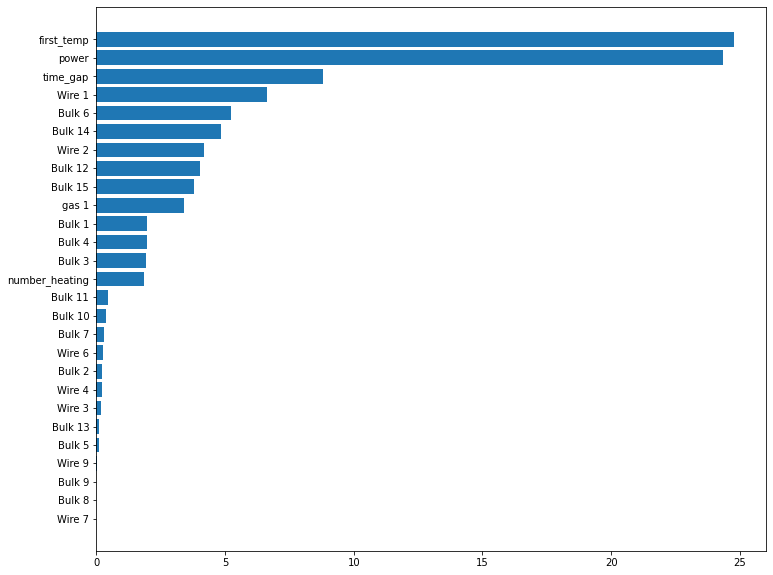

In [85]:
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(12, 10))
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(x_train.columns)[indices])

### Вывод: 
Были подготовлены данные и обучены модели, определены важность признаков для каждой модели, с помощью метрики MAE сравнили их эффективность.

Лучший результат показала модель Catboost на тренировочной выборке:5.47, MAE на тестовой 5.71

## Итоговый вывод

**Для оптимизации расхода электроэнергии заказчику нужно предсказывать последнюю температуру нагрева технического процесса плавления, чтобы использовать эти данные для контролирования процесса.**

- Составлен план работы
- Загружены данные
- Проведен исследовательский анализ, в ходе которого были удалены выбросы и устранены пропсуки, изменены типы данных, где это потребовалось, сформирован финальный датасет, проверены признаки на мультиколлинеарность (по колрреляционной матрице выявлены признаки для удаления из таблицы)
- Созданы обучающая и тестовая выборки для моделей с использованием масштабирования.
- Обучили модели: LinearRegression, RandomForest, LGBM, CatBoost
- Лучшая модель была протестирована на тестовом наборе
- Построен график важности факторов, из которого следует, что наиболее вважными факторами являются первая температура и полная мощность, значит, регулируя их, заказчик сможет использовать эти данные для оптимизации расхода электроэнергии.


## Отчет по проделанной работе

**Какие пункты плана были выполнены, а какие — нет?**

Были выполнены все пункты плана работы. Вяснилось, что датасеты bulk_time и wire_time не имеют существенного веса в использовании для решения поставленной задачи.

**Какие трудности возникли и как вы их преодолели?**

Основной трудностью при выполнении работы - понимание технических процессов работы, не совсем было понятно какие данные нужны для решения поставленной задачи. Также возникла трудность с удалением выбросов, поскольку в промышленной аналитике статистические выбросы - не всегда те выбросы, которые надо удалять, если стремиться к хорошему результату метрики MAE, то выбросы значительно влияют на результат работы моделей. 

**Какие ключевые шаги в решении задачи выделили?**

Ключевые шаги были в предобработке данных и исслевательском анализе, из котрого происходит понимание, какой признак является целевым, также в исследовательском анализе было важно проверить признаки на мультиколлинеарность для того, чтобы модели не переобучались. После этого идет обучение моделей, где подбираются гиперпараметры и проводится анализ резульатата моделей.

**Какая ваша итоговая модель и какое у неё качество?**

Итоговой моделью стала CatBoost , которая показала результат метрики MAE на обучающей выброке -5.47, на тестовой -5.71. Такой результат показывает, что модель в среднем ошибается на 5-6 градусов конечной температуры.
Основные параметры моделя победителя: 'iterations': 1000, 'random_seed': 3102022,'depth': 6, 'min_data_in_leaf': 1, 'learning_rate': 0.04466300085186958,'max_leaves': 64.
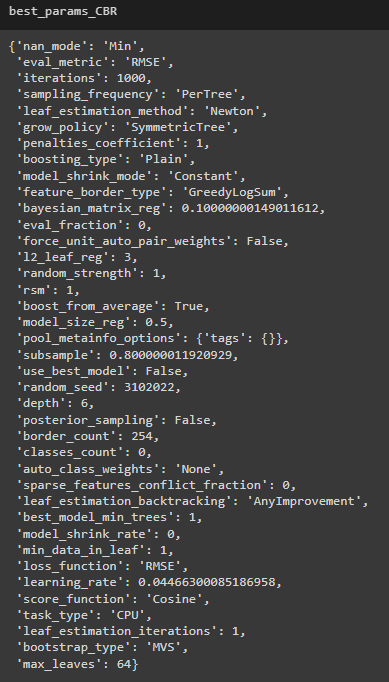

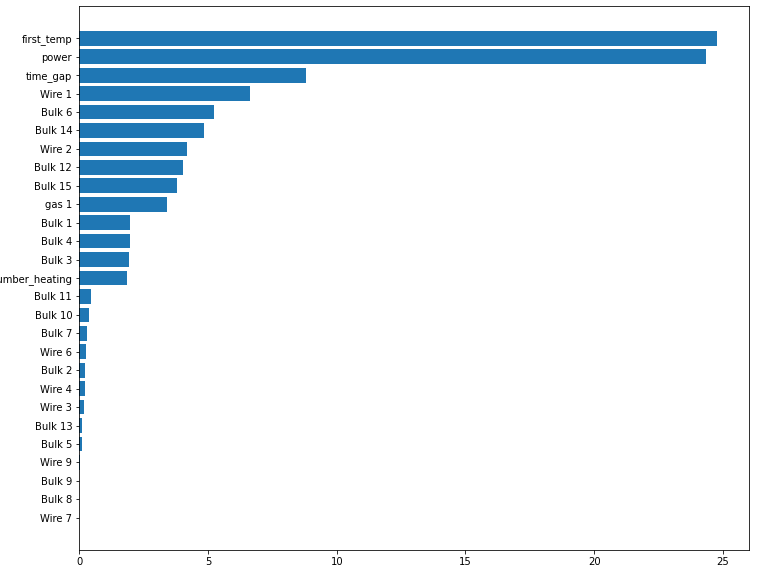

При проведении анализа, некоторые переменные оказываются ненужными, если исключить их из анализа, то при решении нашей задачи, мы даже в худшем случае почти ничего не потеряем. Чтобы подтвердить эту гипотезу использовали метод feature_importances_, который показывает какие факторы оказывают сильное влияние на точность модели. Конкретно в моем случае лишние факторы можно не удалять, хоть это и вляется шумом для модели. 
Можно сказать, что самые влиятельные факторы это первая температура и полная мощность, лишние - wire 7, wire 9, bulk 8, bulk 9.
Перед моделированием исходя из корреляционной матрицы были убраны некоторые факторы, сильно коррелирующие между собой, они влияли бы на модель в худшую сторону, например, wire 5, wire 8

Перед моделированием мы разбили данные на тренировочную и тестовую выборку 75:25, используя random_state = 3102022. Далее было проведено масштабирование признаков и нормализация с помощью MinMaxScaler, позволяющая произвести нормализацию данных перед использованием в модели, то есть приведение числовых переменных к диапазону от 0 до 1, многие алгоритмы машинного обучения работают лучше, когда числовые входные переменные приводятся к определенному диапазону.